# Example notebook

- now with ConvLSTM model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os, sys
import pandas as pd

# Data import

- paths

In [2]:
#os.chdir("/Users/schmidle/Documents/GIT-Projects/DeepHydro")
data_folder = '../Datasample'
data_prec = '01_prec_data_sample.nc'
data_temp = '01_temp_data_sample.nc'
data_disc = '01_discharge_sample.csv'

- read output data

In [3]:
def read_output_data(data_folder:str, data_disc:str):
    # read csv file
    df = pd.read_csv(os.path.join(data_folder, data_disc))
    # calculate the difference to midsummer
    df['DOY'] = pd.DatetimeIndex(df['Time']).dayofyear
    # calculate the difference to midsummer
    df['DiffToMidSummer'] = abs( pd.DatetimeIndex(df['Time']).dayofyear - 365/2)
    return df

In [4]:
df = read_output_data(data_folder, data_disc)
df.head()

Unnamed: 0        Time    Q  DOY  DiffToMidSummer
0       27455  1950-01-01  558    1            181.5
1       27456  1950-01-02  547    2            180.5
2       27457  1950-01-03  541    3            179.5
3       27458  1950-01-04  541    4            178.5
4       27459  1950-01-05  564    5            177.5

In [5]:
def plot_streamflow(df, n_labels=10):
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Q'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels)) # limit number of dates on x axis
    fig.autofmt_xdate() # rotate data labels
    plt.show()

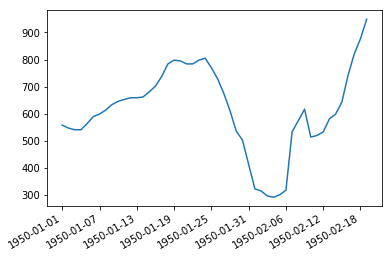

In [6]:
plot_streamflow(df)

- read input data (NetCDF4)

In [7]:
def read_data(filename, folder):
    import netCDF4
    dat = netCDF4.Dataset(os.path.join(folder, filename))
    print(filename)
    arr = np.array(dat.variables['variable'])
    mask = arr < 0
    arr[ mask ] = 0.0
    return arr, mask

def plot_frame(temp:np.array, prec:np.array, mask:np.array, df:pd.DataFrame, frame:int, limits:tuple=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    im_t = np.ma.masked_array(temp[frame], mask=mask[frame])
    im_p = np.ma.masked_array(prec[frame], mask=mask[frame])
    
    ax[0].set_title('Temperature')
    if limits is None:
        cb1 = ax[0].imshow(im_t)
    else:
        cb1 = ax[0].imshow(im_t, vmin=limits[0], vmax=limits[1])
    fig.colorbar(cb1, ax=ax[0], orientation='horizontal')

    ax[1].set_title('Precipitation')
    if limits is None:
        cb2 = ax[1].imshow(im_p)
    else:
        cb2 = ax[1].imshow(im_p, vmin=limits[2], vmax=limits[3])
    fig.colorbar(cb2, ax=ax[1], orientation='horizontal')
    
    for a in ax: a.axis('off')
        
    plt.show()


In [8]:
temp, mask = read_data(data_temp, data_folder)
prec, mask = read_data(data_prec, data_folder)

01_temp_data_sample.nc
01_prec_data_sample.nc


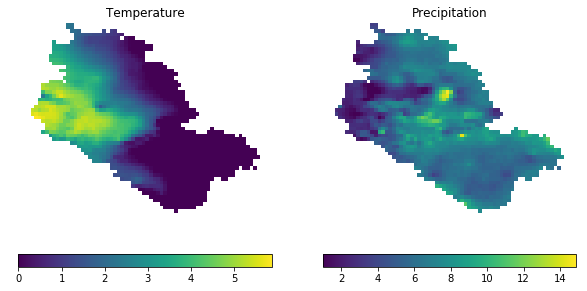

In [9]:
plot_frame(temp, prec, mask, df, frame=11)

# Data preparation

- standardize output data (`y`)

In [10]:
def standardize(data:np.array, return_moments=False):
    mean = np.mean(data)
    std = np.std(data)
    if return_moments:
        return (data-mean)/std, mean, std
    else:
        return (data-mean)/std

Shape of y =  (50,)


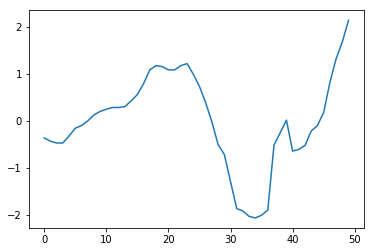

In [11]:
y, Y_MEAN, Y_STD = standardize(df['Q'].values, return_moments=True)
print('Shape of y = ', y.shape)

# plot data
plt.plot(y)

- standardize and combine input image (`x`)

Shape of x =  (50, 53, 66, 2)


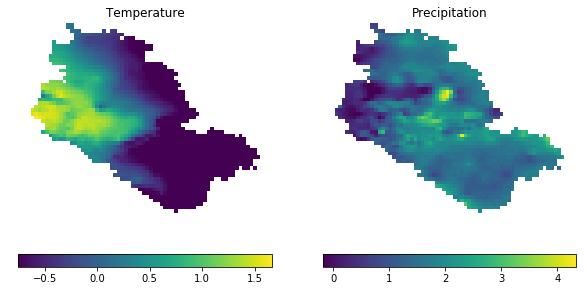

In [12]:
x_t = standardize(np.ma.masked_array(temp, mask=mask))
x_p = standardize(np.ma.masked_array(prec, mask=mask))
x = np.stack([x_t, x_p], axis=-1)
print('Shape of x = ', x.shape)

# plot sample frame
plot_frame(x_t, x_p, mask, df, frame=11)

- split train and test set
   - here: we don't use `train_test_split` anymore because we are dealing with sequences.
   - we simply take the first part as training data, and the last part as test data

In [13]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)
train_size = int(0.75 * len(x))
x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

In [14]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_test  = ', x_test.shape)
print('Shape of y_test  = ', y_test.shape)


Shape of x_train =  (37, 53, 66, 2)
Shape of y_train =  (37,)
Shape of x_test  =  (13, 53, 66, 2)
Shape of y_test  =  (13,)


## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [15]:
from keras import utils
class ImageSequenceGenerator(utils.Sequence):
    '''Generates image sequences'''
    def __init__(self, data, labels, batch_size=32, n_frames=5):
        '''Initialization'''
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_frames = n_frames

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''
        
        batch_x, batch_y = [], []
        
        for _ in range(self.batch_size):
            # Get start index of sequence
            start_index = np.random.randint(0, len(self.data)-self.n_frames)
            stop_index  = start_index + self.n_frames

            # x = image sequence
            x = self.data[start_index:stop_index]
            # y = streamflow at end point
            y = self.labels[stop_index]
            batch_x.append(x)
            batch_y.append(y)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        
        return batch_x, batch_y
    

Using TensorFlow backend.


In [17]:
n_frames = 7 # length of image sequence: how many days of data to predict streamflow?  
batch_size = 2 # adjust this to available GPU memory (VRAM)
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)
generator_test  = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)

In [18]:
batch = generator_train.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')


Shape of batch_x = (2, 7, 53, 66, 2)
Shape of batch_y = (2,)


# Model

- simple ConvLSTM model...
- predicts the streamflow from a short sequence of temperature and precipitation...

In [19]:
def get_conv_lstm_model(input_shape:tuple, n_layers:int=3, n_filters:int=16):
    
    from keras import layers, models
    print(input_shape)
    i = layers.Input(shape=input_shape) # (?, n_frames, height, width, channels) 
    x = i
    for _, _ in enumerate(range(n_layers)):
        # these ConvLSTM layers output sequence: `return_sequences=True`
        x = layers.xc(n_filters, kernel_size=(3,3), strides=(2,2),
                              activation='tanh', recurrent_activation='hard_sigmoid', 
                              return_sequences=True)(x)
        x = layers.BatchNormalization()(x)
        n_filters *= 2
    
    # this ConvLSTM layer only returns value for last point in sequence: `return_sequence = False`
    x = layers.ConvLSTM2D(n_filters, kernel_size=(3,3), strides=(2,2),
                         activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False)(x)
        
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    o = layers.Dense(1, activation='linear')(x)
    return models.Model(inputs=[i], outputs=[o])

def build_model(model):
    from keras import optimizers, losses, metrics
    
    model.compile(optimizer=optimizers.Adam(lr=1e-3),
                 loss=losses.mse)
                 #metrics=[metrics.mse])

In [20]:
input_shape = (n_frames, *x.shape[1:])
model = get_conv_lstm_model(input_shape)
build_model(model)
model.summary()

(7, 53, 66, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 53, 66, 2)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 7, 26, 32, 16)     10432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 26, 32, 16)     64        
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 7, 12, 15, 32)     55424     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 12, 15, 32)     128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 7, 5, 7, 64)       221440    
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 5, 7, 64)       256   

# Training

In [21]:
n_epochs = 40

In [25]:
history = model.fit_generator(generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size)

Epoch 1/30
18/18 [==============================] - 40s 2s/step - loss: 0.1947 - val_loss: 0.2133
Epoch 2/30
18/18 [==============================] - 31s 2s/step - loss: 0.3012 - val_loss: 0.1156
Epoch 3/30
18/18 [==============================] - 39s 2s/step - loss: 0.1828 - val_loss: 0.2386
Epoch 4/30
18/18 [==============================] - 33s 2s/step - loss: 0.2394 - val_loss: 0.0876
Epoch 5/30
18/18 [==============================] - 35s 2s/step - loss: 0.0992 - val_loss: 0.1544
Epoch 6/30
18/18 [==============================] - 32s 2s/step - loss: 0.1120 - val_loss: 0.0126
Epoch 7/30
18/18 [==============================] - 38s 2s/step - loss: 0.0949 - val_loss: 0.1723
Epoch 8/30
18/18 [==============================] - 35s 2s/step - loss: 0.1532 - val_loss: 0.2772
Epoch 9/30
18/18 [==============================] - 32s 2s/step - loss: 0.0552 - val_loss: 0.0317
Epoch 10/30
18/18 [==============================] - 41s 2s/step - loss: 0.1007 - val_loss: 0.1625
Epoch 11/30
18/18 [

In [ ]:
model.save('./model2.h5')

In [26]:
def plot_history(history):
    nr = len(history.history.keys())
    fig, ax = plt.subplots(nr, 1, figsize=(6,3*nr), sharex=True)
    fig.tight_layout(h_pad=0)
    ax = ax.flatten()
    for i, key in enumerate(history.history.keys()):
        print(key)
        ax[i].plot(history.history[key], label=key)
        ax[i].legend()
    ax[i].set_xlabel('epoch')
    plt.show()

val_loss
loss


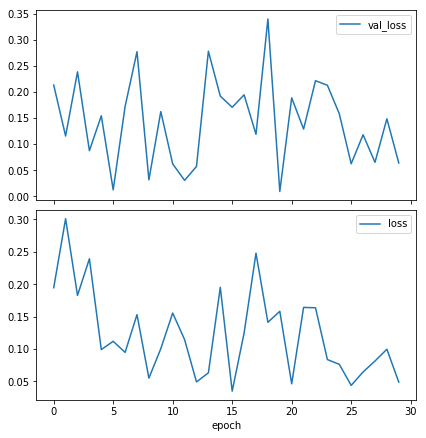

In [27]:
plot_history(history)

# Predict

In [61]:
def predict(model, image, gt=None, plot=False):
    
    im = image[np.newaxis, ...] # add batch dimension

    t = im[..., 0] # get temperature
    p = im[..., 1] # get precipitation

    limits = (t.min(), t.max(), p.min(), p.max())
    
    y_pred = model.predict(im)[0,0] # get first element

    # calculate back to original units
    y_pred = Y_MEAN + y_pred * Y_STD

    if plot:
        for frame in range(len(t[0])):
            print(f'Day {frame+1}')
            plot_frame(t[:,frame], p[:,frame], mask, df, 0, limits=limits)

    if gt is not None:
        y_true = Y_MEAN + gt * Y_STD
        if plot:
            print(f'Predicted streamflow = {y_pred:.1f}, ground truth = {y_true:.1f}')
        return y_pred, y_true
    else:
        print(f'Predicted streamflow = {y_pred:.1f}')
        return y_pred

Day 1


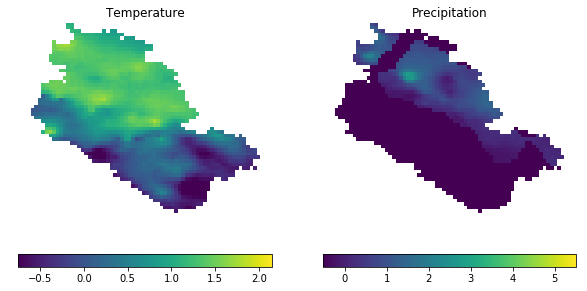

Day 2


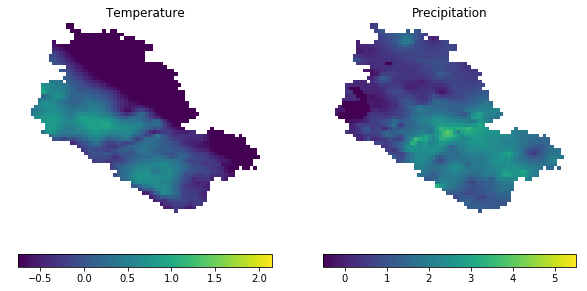

Day 3


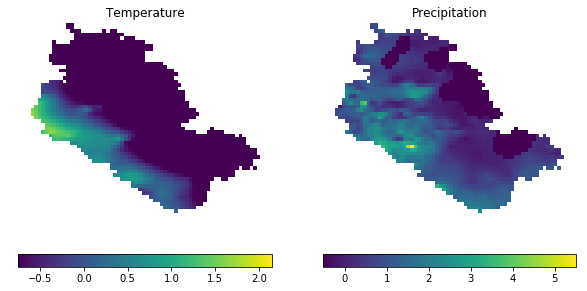

Day 4


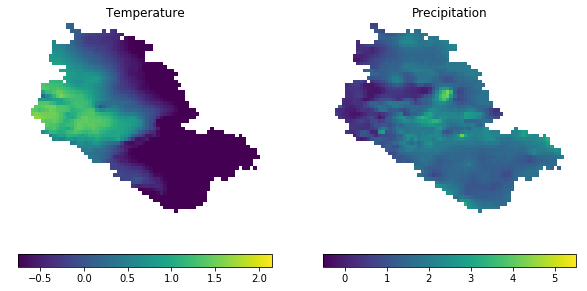

Day 5


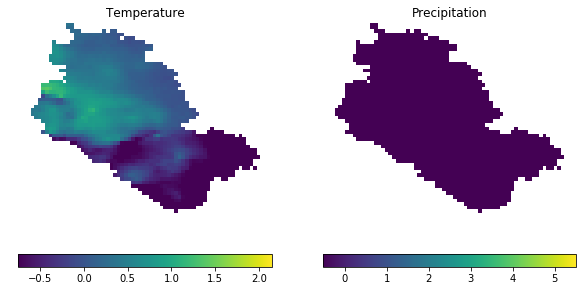

Day 6


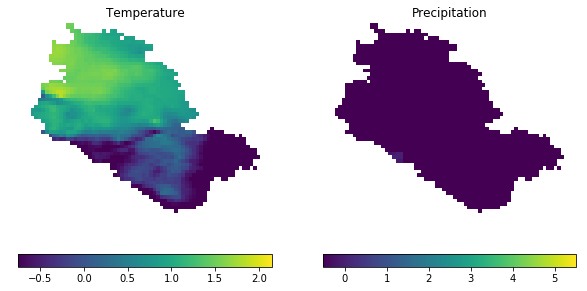

Day 7


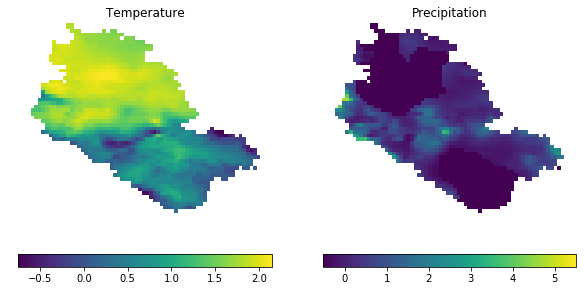

Predicted streamflow = 678.0, ground truth = 702.0


In [62]:
random_test_sample = generator_test.__getitem__(0) # get single sample from batch
_ = predict(model, random_test_sample[0][0], gt=random_test_sample[1][0], plot=True)

## Evaluate prediction accuracy

- predict streamflow in multiple image sequences
- compare with ground truth streamflow
- using Lin's concordance correlation coefficient - basically Pearson correlation, corrected for bias


(270.18393878239226, 837.4987995465262, 266.33482339955845, 830.6651766004416)

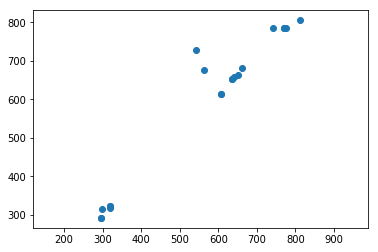

In [82]:
y_preds, y_trues = [], []
from tqdm import tqdm_notebook as tqdm
for _  in tqdm(range(20)):
    random_test_sample = generator_test.__getitem__(0) # get single sample from batch
    y_pred, y_true = predict(model, random_test_sample[0][0], gt=random_test_sample[1][0], plot=False)
    y_preds.append(y_pred)
    y_trues.append(y_true)

plt.scatter(y_preds, y_trues)
plt.axis('equal')


In [83]:
def ccc_numpy(y_true, y_pred):
    import numpy as np
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient'''
    
    # covariance between y_true and y_pred
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    s_xy = np.cov([y_true, y_pred])[0,1] #[1,0] is the identical covariance between y_pred and y_true 
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

In [84]:
print(f'Concordance correlation coefficient  = {ccc_numpy(y_trues, y_preds):.3f}')

Concordance correlation coefficient  = 1.014


# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [63]:
#from keras.models import load_model
#model = load_model('./model.h5')

In [64]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
# return a list of tuples
background = np.mean(np.array([np.mean(generator_train.__getitem__(0)[0], axis=0) for _ in range(20)]), axis=0)
print(background.shape)
print(background[np.newaxis, ...].shape)

# explain predictions
e = shap.DeepExplainer(model, background[np.newaxis, ...])

test_sample = random_test_sample[0][0]
shap_values = e.shap_values(test_sample[np.newaxis, ...])

# plot the feature attributions
#shap.image_plot(shap_values, -test_sample[np.newaxis, 0, ..., 0])

/Users/wdeback/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(7, 53, 66, 2)
(1, 7, 53, 66, 2)


In [65]:
print(len(shap_values))
print(shap_values[0].shape)
print(shap_values[0][0].shape)

1
(1, 7, 53, 66, 2)
(7, 53, 66, 2)


- plot saliency map

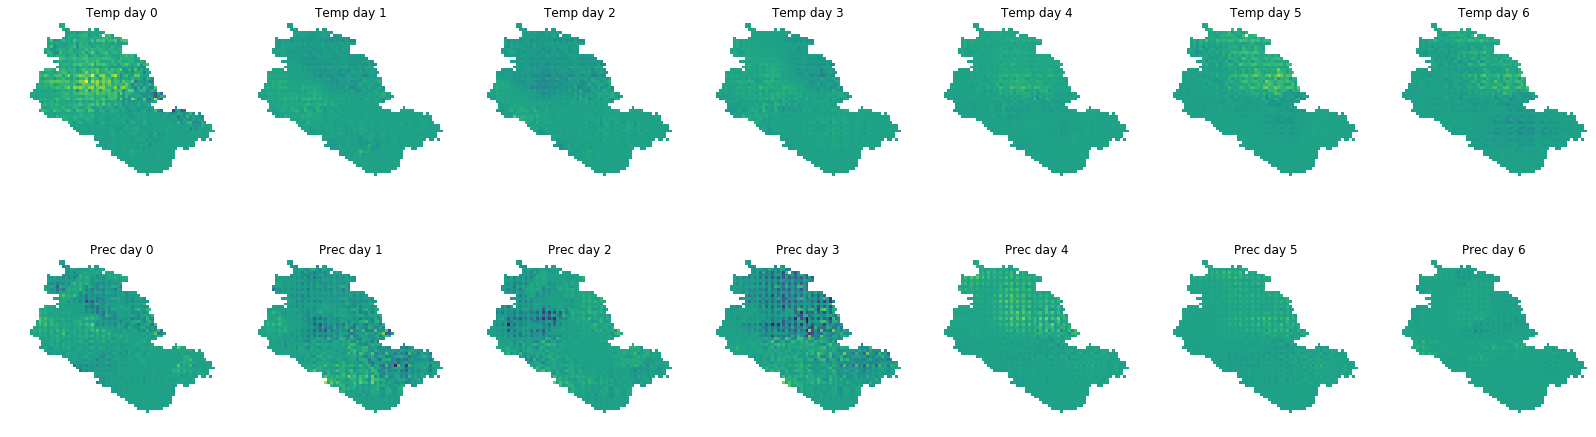

In [66]:
fig, ax = plt.subplots(2, n_frames, figsize=(n_frames*4, 2*4)) 

for frame in range(len(shap_values[0][0])):
    
    ax[0,frame].set_title(f'Temp day {frame}')#'{-n_frames+frame+1}')
    vmin = np.min( shap_values[0][0])
    vmax = np.max( shap_values[0][0])

    vmin_t = np.min( shap_values[0][0, ..., 0])
    vmax_t = np.max( shap_values[0][0, ..., 0])
    im_t = np.ma.masked_array(shap_values[0][0, frame, ..., 0], mask=mask[frame])
    ax[0, frame].imshow(im_t, vmin=vmin, vmax=vmax)
    ax[0, frame].axis('off')
    
    ax[1, frame].set_title(f'Prec day {frame}')#'{-n_frames+frame+1}')
    vmin_p = np.min( shap_values[0][0, ..., 1])
    vmax_p = np.max( shap_values[0][0, ..., 1])
    im_p = np.ma.masked_array(shap_values[0][0, frame, ..., 1], mask=mask[frame])
    ax[1, frame].imshow(im_p, vmin=vmin, vmax=vmax)
    ax[1, frame].axis('off')
    
    
plt.show()